In [328]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]')\
.appName('airbnb-prediction').getOrCreate()
df = spark.read.parquet('listings.parquet', header = True, inferSchema = True)
df.select("neighbourhood_cleansed", "room_type", "bedrooms", "bathrooms",
 "number_of_reviews", "price").show(5)

+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



In [329]:
df= df.select("neighbourhood_cleansed", "room_type", "bedrooms", "bathrooms",
 "number_of_reviews", "price")
trainDF, testDF = df.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set,
and {testDF.count()} in the test set""")

There are 5780 rows in the training set,
and 1366 in the test set


In [330]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")
vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.select("bedrooms", "features", "price").show(10)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     0.0|   [0.0]| 99.0|
|     0.0|   [0.0]| 60.0|
|     0.0|   [0.0]|100.0|
|     0.0|   [0.0]|110.0|
|     0.0|   [0.0]|149.0|
|     1.0|   [1.0]|250.0|
|     1.0|   [1.0]| 95.0|
|     1.0|   [1.0]|130.0|
|     1.0|   [1.0]|109.0|
|     1.0|   [1.0]|127.0|
+--------+--------+-----+
only showing top 10 rows



In [331]:
# lr.fit() returns a LinearRegressionModel (lrModel), which is a transformer
# In other words, the output of an estimator’s fit() method is a transformer
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="price")
lrModel = lr.fit(vecTrainDF)
m = round(lrModel.coefficients[0], 2)
b = round(lrModel.intercept, 2)
print(f"""The formula for the linear regression line is
price = {m}*bedrooms + {b}""")

The formula for the linear regression line is
price = 121.53*bedrooms + 51.8


In [332]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

predDF = pipelineModel.transform(testDF)
predDF.select("bedrooms", "features", "price", "prediction").show(5)

+--------+--------+-----+------------------+
|bedrooms|features|price|        prediction|
+--------+--------+-----+------------------+
|     0.0|   [0.0]|115.0|  51.7988030413165|
|     0.0|   [0.0]|199.0|  51.7988030413165|
|     1.0|   [1.0]| 95.0|173.33189308801815|
|     1.0|   [1.0]| 88.0|173.33189308801815|
|     1.0|   [1.0]| 99.0|173.33189308801815|
+--------+--------+-----+------------------+
only showing top 5 rows



In [333]:
from pyspark.ml.evaluation import RegressionEvaluator
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

R2 is 0.23959257292844993


In [334]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

categoricalCols = [field for (field, dataType) in trainDF.dtypes
                   if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols,                       
    outputCols=indexOutputCols,
    handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                           outputCols=oheOutputCols)
numericCols = [field for (field, dataType) in trainDF.dtypes
               if ((dataType == "double") & (field != "price"))]

assemblerInputs = oheOutputCols + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs,
 outputCol="features")

In [335]:
from pyspark.ml.feature import RFormula
rFormula = RFormula(formula="price ~ .",
    featuresCol="features",
    labelCol="price",
    handleInvalid="skip")

In [336]:
lr = LinearRegression(labelCol="price", featuresCol="features", )
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("features", "price", "prediction").show(5)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(40,[15,35,38,39]...|115.0| 5.219459229122052|
|(40,[15,35,38,39]...|199.0|-5.485956453427008|
|(40,[15,35,37,38,...| 95.0|113.94354528880599|
|(40,[15,35,37,38,...| 88.0|110.37507339462296|
|(40,[15,35,37,38,...| 99.0| 104.1897221113724|
+--------------------+-----+------------------+
only showing top 5 rows



In [337]:
# use RFormula
lr = LinearRegression(labelCol="price", featuresCol="features", )
pipeline = Pipeline(stages = [rFormula, lr])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("features", "price", "prediction").show(5)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(40,[15,35,38,39]...|115.0| 5.219459229122052|
|(40,[15,35,38,39]...|199.0|-5.485956453427008|
|(40,[15,35,37,38,...| 95.0|113.94354528880599|
|(40,[15,35,37,38,...| 88.0|110.37507339462296|
|(40,[15,35,37,38,...| 99.0| 104.1897221113724|
+--------------------+-----+------------------+
only showing top 5 rows



## Evaluating Models

In [338]:
from pyspark.ml.evaluation import RegressionEvaluator
regressionEvaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="price",
    metricName="rmse")
rmse = regressionEvaluator.evaluate(predDF)
print(f"RMSE is {rmse:.1f}")

RMSE is 184.4


In [339]:
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

R2 is 0.2923250512096982


## Exploring Dataset

<AxesSubplot:title={'center':'Distribution of Housing Prices'}, ylabel='Frequency'>

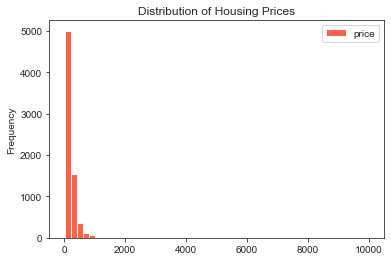

In [340]:
df.select("price").sort("price", ascending= False)\
.toPandas().plot\
.hist(bins= 50, title= "Distribution of Housing Prices",
     color= 'tomato')

<AxesSubplot:title={'center':'Logarithmic Distribution of Housing Prices'}, ylabel='Frequency'>

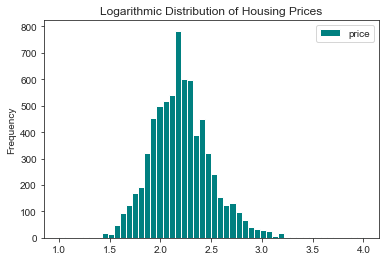

In [341]:
from pyspark.sql.functions import log10, col
df.select("price")\
.withColumn("price", log10(col("price")))\
.sort("price", ascending= False)\
.toPandas().plot\
.hist(bins= 50, title= "Logarithmic Distribution of Housing Prices", color= 'teal')

In [342]:
trainDF.withColumn("price", log10(col("price"))).show(5)
#trainDF.show(5)

+----------------------+---------------+--------+---------+-----------------+------------------+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|             price|
+----------------------+---------------+--------+---------+-----------------+------------------+
|               Bayview|Entire home/apt|     0.0|      1.0|              2.0|  1.99563519459755|
|               Bayview|Entire home/apt|     0.0|      1.0|              3.0|1.7781512503836436|
|               Bayview|Entire home/apt|     0.0|      1.0|             20.0|               2.0|
|               Bayview|Entire home/apt|     0.0|      1.0|             39.0| 2.041392685158225|
|               Bayview|Entire home/apt|     0.0|      1.0|             95.0| 2.173186268412274|
+----------------------+---------------+--------+---------+-----------------+------------------+
only showing top 5 rows



In [343]:
trainDF.withColumn("price", log10(col("price")))\
.withColumn("number_of_reviews", log(col("number_of_reviews"))).show(5)

+----------------------+---------------+--------+---------+------------------+------------------+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms| number_of_reviews|             price|
+----------------------+---------------+--------+---------+------------------+------------------+
|               Bayview|Entire home/apt|     0.0|      1.0|0.6931471805599453|  1.99563519459755|
|               Bayview|Entire home/apt|     0.0|      1.0|1.0986122886681096|1.7781512503836436|
|               Bayview|Entire home/apt|     0.0|      1.0| 2.995732273553991|               2.0|
|               Bayview|Entire home/apt|     0.0|      1.0|3.6635616461296463| 2.041392685158225|
|               Bayview|Entire home/apt|     0.0|      1.0| 4.553876891600541| 2.173186268412274|
+----------------------+---------------+--------+---------+------------------+------------------+
only showing top 5 rows



In [344]:
from pyspark.ml.feature import RFormula
rFormula = RFormula(formula="price ~ .",
    featuresCol="features",
    labelCol="price",
    handleInvalid="skip")

In [345]:
trainDF= trainDF.withColumn("price", log10(col("price")))
lr = LinearRegression(labelCol="price", featuresCol="features", )
pipeline = Pipeline(stages = [rFormula, lr])
pipelineModel = pipeline.fit(trainDF)

In [346]:
testDF= testDF.withColumn("price", log10(col("price")))
predDF = pipelineModel.transform(testDF)
predDF.select("features", "price", "prediction").show(5)

+--------------------+------------------+------------------+
|            features|             price|        prediction|
+--------------------+------------------+------------------+
|(40,[15,35,38,39]...| 2.060697840353612| 1.903884654822569|
|(40,[15,35,38,39]...| 2.298853076409707| 1.899111693969867|
|(40,[15,35,37,38,...|1.9777236052888478| 2.052488947194184|
|(40,[15,35,37,38,...|1.9444826721501687| 2.050897960243283|
|(40,[15,35,37,38,...|  1.99563519459755|2.0481402495283887|
+--------------------+------------------+------------------+
only showing top 5 rows



In [347]:
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

R2 is 0.5438922389401064


In [ ]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
sb.set_style("ticks")
sb.pairplot(trainDF.toPandas(), hue= "room_type", diag_kind = "kde",kind = "scatter",palette = "husl")
plt.show()

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="price", maxBins=40, seed=42)

trainDF_rf= trainDF\
.withColumn("price", log10(col("price")))\
.withColumn("number_of_reviews", log(col("number_of_reviews"))).dropna()

pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, rf])
pipelineModel = pipeline.fit(trainDF_rf)

testDF_rf= testDF\
.withColumn("price", log10(col("price")))\
.withColumn("number_of_reviews", log(col("number_of_reviews"))).dropna()

predDF = pipelineModel.transform(testDF_rf)
predDF.select("features", "price", "prediction").show(5)

In [ ]:
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

## Cross Validation

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = (ParamGridBuilder()
    .addGrid(rf.maxDepth, [2, 4, 6])
    .addGrid(rf.numTrees, [10, 100])
    .build())
evaluator = RegressionEvaluator(labelCol="price",
    predictionCol="prediction",
    metricName="r2")

In [ ]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=pipeline,
 evaluator=evaluator,
 estimatorParamMaps=paramGrid,
 numFolds=3,
 seed=42)
cvModel = cv.fit(trainDF_rf)

In [ ]:
list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))